# Notebook 02 — Feature Engineering & Stress Index

This notebook assumes that **Notebook 01** has already:

- Uploaded and checked `data/raw/sample_prices.csv`.

Here we:

1. Load `data/raw/sample_prices.csv`.
2. Compute daily **log returns** using `compute_log_returns` from
   `src/bank_stress/features.py`.
3. Compute:
   - per-bank **rolling volatility**
   - **average rolling pairwise correlation** between banks.
4. Build a **stress index** using:
   - `build_stress_components`
   - `build_stress_index`
   from `src/bank_stress/index.py`.
5. Save the processed datasets to `data/processed/` and plots to
   `results/figures/`.

**No labeling is done here.** Labels will be constructed in Notebook 03
using `labels.py`.

In [1]:
# --- Cell 2: Fix working directory and make src/ importable ---

import os
import sys
from pathlib import Path

# The notebook file lives in <project_root>/notebooks,
# so the project root is one level up.
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Change working directory so that all relative paths (data/, src/, results/)
# are resolved from the project root.
os.chdir(PROJECT_ROOT)

# Ensure src/ is on sys.path so that imports like "from bank_stress.features"
# work correctly.
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Running from:", Path.cwd())
print("SRC_DIR:", SRC_DIR)

Running from: /files/bank_stress_detection_project_datascience_class
SRC_DIR: /files/bank_stress_detection_project_datascience_class/src


In [2]:
# --- Cell 3: Imports and define data/figure paths ---

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from bank_stress.features import (
    compute_log_returns,
    rolling_volatility,
    rolling_pairwise_correlation,
    average_crossbank_stat,
)
from bank_stress.index import build_stress_components, build_stress_index

# Directories for raw and processed data and figures.
RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results" / "figures"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Path to the cleaned price CSV produced in Notebook 01.
PRICES_PATH = RAW_DIR / "sample_prices.csv"

print("Prices CSV:     ", PRICES_PATH.resolve())
print("Processed dir:  ", PROCESSED_DIR.resolve())
print("Figures dir:    ", RESULTS_DIR.resolve())

Prices CSV:      /files/bank_stress_detection_project_datascience_class/data/raw/sample_prices.csv
Processed dir:   /files/bank_stress_detection_project_datascience_class/data/processed
Figures dir:     /files/bank_stress_detection_project_datascience_class/results/figures


In [3]:
# --- Cell 4: Load and sanitize price data ---

if not PRICES_PATH.exists():
    raise FileNotFoundError(
        "sample_prices.csv not found at "
        f"{PRICES_PATH}. Run Notebook 01 or check the path."
    )

prices = pd.read_csv(
    PRICES_PATH,
    index_col=0,
    parse_dates=True,
    encoding="utf-8",
)

# Ensure the index is a proper DatetimeIndex and drop any invalid dates.
prices.index = pd.to_datetime(prices.index, errors="coerce")
prices = prices.loc[~prices.index.isna()]
prices = prices.sort_index()

# Clean up column names and remove Excel-style "Unnamed" columns.
prices.columns = [str(col).strip() for col in prices.columns]
prices = prices.loc[:, ~prices.columns.str.match(r"^Unnamed")]

# Convert all columns to numeric; non-numeric entries become NaN.
for col in prices.columns:
    prices[col] = pd.to_numeric(prices[col], errors="coerce")

# Drop columns that are entirely NaN.
prices = prices.loc[:, ~prices.isna().all()]

if prices.empty:
    raise ValueError(
        "Loaded prices DataFrame is empty after cleaning. "
        "Check sample_prices.csv formatting."
    )

print("Loaded price data (head):")
display(prices.head())
print("Shape (rows, tickers):", prices.shape)
print("Tickers:", list(prices.columns))

Loaded price data (head):


,JPM,BAC,C,WFC,GS,MS,USB,PNC,TFC,CMA,CFG
Date,,,,,,,,,,,
2000-01-03 00:00:00-05:00,23.013842,12.490806,207.768265,9.648853,61.663662,32.863632,8.710556,19.034946,9.855802,19.051611,NaN
2000-01-04 00:00:00-05:00,22.508884,11.749408,195.027679,9.171043,57.779690,30.429289,8.392846,18.442753,9.569435,18.257793,NaN
2000-01-05 00:00:00-05:00,22.369938,11.878347,202.868027,9.078558,55.073978,29.318615,8.207516,18.527353,9.688752,18.204874,NaN
2000-01-06 00:00:00-05:00,22.687529,12.893735,212.668304,9.479308,57.430576,29.881571,8.842937,19.401554,10.142168,18.734070,NaN
2000-01-07 00:00:00-05:00,23.104355,12.555271,211.688431,9.648853,57.648777,30.809662,9.187122,19.429750,10.213759,18.707626,NaN


Shape (rows, tickers): (2356, 11)
Tickers: ['JPM', 'BAC', 'C', 'WFC', 'GS', 'MS', 'USB', 'PNC', 'TFC', 'CMA', 'CFG']


Saved log returns to: /files/bank_stress_detection_project_datascience_class/data/processed/returns.csv


,JPM,BAC,C,WFC,GS,MS,USB,PNC,TFC,CMA,CFG
Date,,,,,,,,,,,
2000-01-04 00:00:00-05:00,-0.022186,-0.061190,-0.063282,-0.050788,-0.065057,-0.076961,-0.037156,-0.031605,-0.029486,-0.042560,NaN
2000-01-05 00:00:00-05:00,-0.006192,0.010914,0.039414,-0.010136,-0.047960,-0.037183,-0.022329,0.004577,0.012391,-0.002903,NaN
2000-01-06 00:00:00-05:00,0.014097,0.082024,0.047178,0.043196,0.041900,0.019019,0.074569,0.046105,0.045736,0.028654,NaN
2000-01-07 00:00:00-05:00,0.018206,-0.026601,-0.004618,0.017728,0.003792,0.030586,0.038184,0.001452,0.007034,-0.001413,NaN
2000-01-10 00:00:00-05:00,-0.017331,-0.035275,-0.003479,-0.032470,0.021715,0.034759,-0.005781,-0.035454,-0.026037,-0.033073,NaN


Saved average log return figure to: /files/bank_stress_detection_project_datascience_class/results/figures/avg_log_return.png


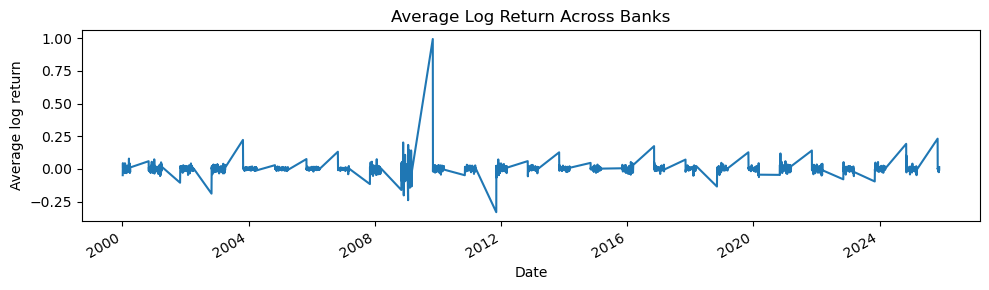

In [4]:
# --- Cell 5: Set parameters and compute log returns ---

# Rolling window length in days (e.g., 20 trading days ≈ 1 month).
ROLLING_WINDOW = 20

# Optional smoothing span for the final stress index (EWMA).
SMOOTH_SPAN = 10

# Compute daily log returns using your function from features.py.
returns = compute_log_returns(prices)

if returns.empty:
    raise ValueError(
        "compute_log_returns returned an empty DataFrame. "
        "Check the input price data."
    )

RETURNS_PATH = PROCESSED_DIR / "returns.csv"
returns.to_csv(RETURNS_PATH, index_label="Date")

print("Saved log returns to:", RETURNS_PATH)
display(returns.head())

# Plot the cross-bank average log return as a small sanity check.
fig, ax = plt.subplots(figsize=(10, 3))
returns.mean(axis=1).plot(ax=ax)
ax.set_title("Average Log Return Across Banks")
ax.set_xlabel("Date")
ax.set_ylabel("Average log return")
fig.tight_layout()

avg_return_fig = RESULTS_DIR / "avg_log_return.png"
fig.savefig(avg_return_fig, dpi=150)
print("Saved average log return figure to:", avg_return_fig)
plt.show()

Saved rolling volatility to: /files/bank_stress_detection_project_datascience_class/data/processed/rolling_vol.csv


,JPM,BAC,C,WFC,GS,MS,USB,PNC,TFC,CMA,CFG
Date,,,,,,,,,,,
2000-01-04 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00-05:00,0.011309,0.050985,0.072617,0.028746,0.012090,0.028127,0.010484,0.025584,0.029612,0.028042,NaN
2000-01-06 00:00:00-05:00,0.018184,0.071608,0.061655,0.047134,0.057456,0.048224,0.060679,0.038886,0.037692,0.035684,NaN
2000-01-07 00:00:00-05:00,0.018770,0.061352,0.050721,0.040259,0.048886,0.050205,0.052244,0.031845,0.030801,0.029211,NaN
2000-01-10 00:00:00-05:00,0.018201,0.055592,0.044077,0.037768,0.045711,0.049076,0.046044,0.033015,0.030918,0.028330,NaN


Saved average rolling volatility figure to: /files/bank_stress_detection_project_datascience_class/results/figures/avg_rolling_vol.png


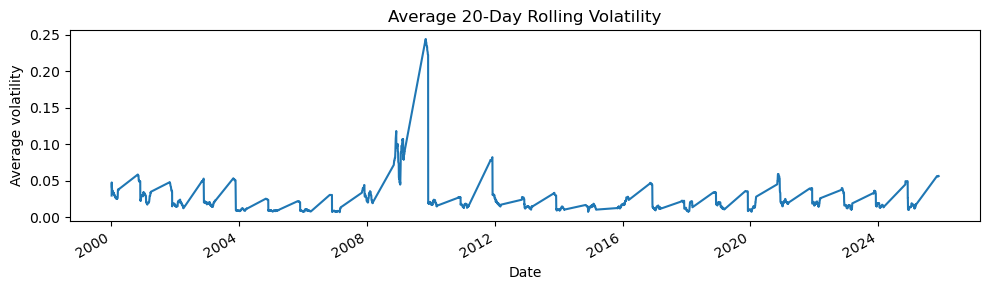

In [5]:
# --- Cell 6: Rolling volatility per bank and average across banks ---

rolling_vol = rolling_volatility(returns, window=ROLLING_WINDOW)

ROLLING_VOL_PATH = PROCESSED_DIR / "rolling_vol.csv"
rolling_vol.to_csv(ROLLING_VOL_PATH, index_label="Date")

print("Saved rolling volatility to:", ROLLING_VOL_PATH)
display(rolling_vol.head())

# Cross-bank average volatility (using your helper average_crossbank_stat).
avg_vol = average_crossbank_stat(rolling_vol)

fig, ax = plt.subplots(figsize=(10, 3))
avg_vol.plot(ax=ax)
ax.set_title(f"Average {ROLLING_WINDOW}-Day Rolling Volatility")
ax.set_xlabel("Date")
ax.set_ylabel("Average volatility")
fig.tight_layout()

avg_vol_fig = RESULTS_DIR / "avg_rolling_vol.png"
fig.savefig(avg_vol_fig, dpi=150)
print("Saved average rolling volatility figure to:", avg_vol_fig)
plt.show()

Saved rolling correlations to: /files/bank_stress_detection_project_datascience_class/data/processed/rolling_corr.csv


,avg_pairwise_corr
Date,
2000-01-04 00:00:00-05:00,NaN
2000-01-05 00:00:00-05:00,1.000000
2000-01-06 00:00:00-05:00,0.943581
2000-01-07 00:00:00-05:00,0.845018
2000-01-10 00:00:00-05:00,0.734889


Saved average rolling correlation figure to: /files/bank_stress_detection_project_datascience_class/results/figures/avg_rolling_corr.png


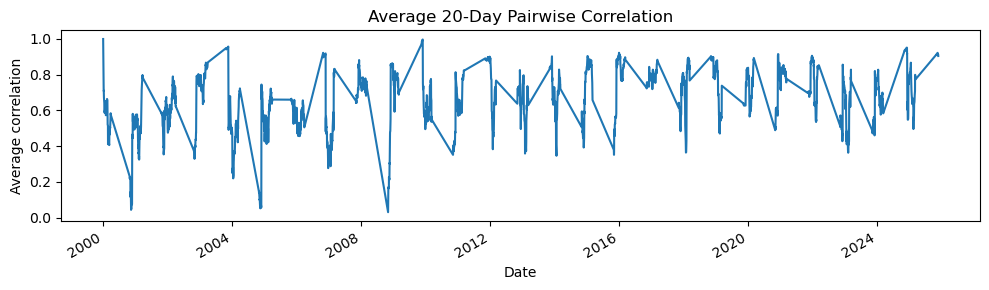

In [6]:
# --- Cell 7: Rolling average pairwise correlation ---

avg_corr_series = rolling_pairwise_correlation(
    returns,
    window=ROLLING_WINDOW,
)

# Store as a single-column DataFrame for convenience.
rolling_corr_df = avg_corr_series.rename("avg_pairwise_corr").to_frame()

ROLLING_CORR_PATH = PROCESSED_DIR / "rolling_corr.csv"
rolling_corr_df.to_csv(ROLLING_CORR_PATH, index_label="Date")

print("Saved rolling correlations to:", ROLLING_CORR_PATH)
display(rolling_corr_df.head())

fig, ax = plt.subplots(figsize=(10, 3))
rolling_corr_df["avg_pairwise_corr"].plot(ax=ax)
ax.set_title(f"Average {ROLLING_WINDOW}-Day Pairwise Correlation")
ax.set_xlabel("Date")
ax.set_ylabel("Average correlation")
fig.tight_layout()

avg_corr_fig = RESULTS_DIR / "avg_rolling_corr.png"
fig.savefig(avg_corr_fig, dpi=150)
print("Saved average rolling correlation figure to:", avg_corr_fig)
plt.show()

In [7]:
# --- Cell 8: Build stress components and full stress index ---

# Components are:
#   - avg_vol  : cross-bank average rolling volatility
#   - avg_corr : average rolling pairwise correlation
components_df = build_stress_components(
    returns,
    window=ROLLING_WINDOW,
)
print("Stress components (head):")
display(components_df.head())

# Build full stress index (z-scored components + linear combination).
stress_index_df = build_stress_index(
    returns,
    window=ROLLING_WINDOW,
    weight_vol=0.5,
    weight_corr=0.5,
    baseline_idx=None,   # use full sample for z-scores
    smooth_span=SMOOTH_SPAN,
)

if stress_index_df.empty:
    raise ValueError(
        "build_stress_index returned an empty DataFrame. "
        "Check the function and inputs."
    )

STRESS_INDEX_PATH = PROCESSED_DIR / "stress_index.csv"
stress_index_df.to_csv(STRESS_INDEX_PATH, index_label="Date")

print("Saved stress index (and components) to:", STRESS_INDEX_PATH)
display(stress_index_df.head())

Stress components (head):


,avg_vol,avg_corr
Date,,
2000-01-04 00:00:00-05:00,NaN,NaN
2000-01-05 00:00:00-05:00,0.029760,1.000000
2000-01-06 00:00:00-05:00,0.047720,0.943581
2000-01-07 00:00:00-05:00,0.041429,0.845018
2000-01-10 00:00:00-05:00,0.038873,0.734889


Saved stress index (and components) to: /files/bank_stress_detection_project_datascience_class/data/processed/stress_index.csv


,avg_vol,avg_corr,z_vol,z_corr,stress_index,stress_index_smooth
Date,,,,,,
2000-01-04 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00-05:00,0.029760,1.000000,0.171645,1.910799,1.041222,1.041222
2000-01-06 00:00:00-05:00,0.047720,0.943581,0.862376,1.588078,1.225227,1.074678
2000-01-07 00:00:00-05:00,0.041429,0.845018,0.620440,1.024293,0.822366,1.028803
2000-01-10 00:00:00-05:00,0.038873,0.734889,0.522139,0.394346,0.458243,0.925065


Saved stress index figure to: /files/bank_stress_detection_project_datascience_class/results/figures/stress_index.png


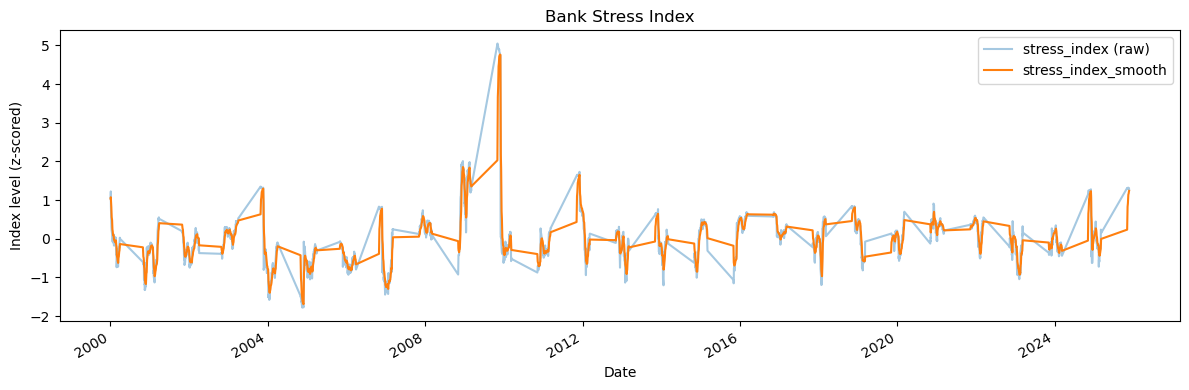


Notebook 02 complete.
Processed data saved in: data/processed/
Figures saved in:      results/figures/
Next: Notebook 03 — Construct labels using labels.py (threshold/event/combined).


In [8]:
# --- Cell 9: Plot stress index and wrap up ---

fig, ax = plt.subplots(figsize=(12, 4))

if "stress_index_smooth" in stress_index_df.columns:
    stress_index_df["stress_index"].plot(
        ax=ax,
        alpha=0.4,
        label="stress_index (raw)",
    )
    stress_index_df["stress_index_smooth"].plot(
        ax=ax,
        label="stress_index_smooth",
    )
else:
    stress_index_df["stress_index"].plot(
        ax=ax,
        label="stress_index",
    )

ax.set_title("Bank Stress Index")
ax.set_xlabel("Date")
ax.set_ylabel("Index level (z-scored)")
ax.legend()
fig.tight_layout()

stress_fig = RESULTS_DIR / "stress_index.png"
fig.savefig(stress_fig, dpi=150)
print("Saved stress index figure to:", stress_fig)

plt.show()

print("\nNotebook 02 complete.")
print("Processed data saved in: data/processed/")
print("Figures saved in:      results/figures/")
print("Next: Notebook 03 — Construct labels using labels.py (threshold/event/combined).")